In [36]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKeras
import os
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation
from keras import optimizers
from sklearn.model_selection import LeaveOneGroupOut, train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
import glob2
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 9)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from readEMG import *
from gesture_accuracy import *

Num GPUs Available:  1


# Read pretraining dataset

In [2]:
X_pretrain, y_pretrain = read_file(mode = 0, window_size = 52, nonoverlap_size = 5)

100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]


# Building CNN

In [3]:
print(X_pretrain.shape)
print(y_pretrain.shape)

(5077, 52, 8)
(5077,)


In [4]:
# Label encoding
le = LabelEncoder()
y_pretrain = le.fit_transform(y_pretrain)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

# One hot encoding
y_pretrain = to_categorical(y_pretrain)
print(y_pretrain.shape)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7}
(5077, 8)


In [5]:
# Train-test-split
X_train, X_val, Y_train, Y_val = train_test_split(X_pretrain, y_pretrain, test_size = 0.10, random_state = 42, stratify = y_pretrain)

In [6]:
# Make sure classes are approximately balanced 
np.unique(np.argmax(Y_train, axis = 1), return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64),
 array([579, 574, 557, 564, 579, 571, 569, 576], dtype=int64))

In [7]:
# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

In [8]:
# define cnn model
def CNN(output_dim):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), 
                     kernel_initializer='he_uniform', 
                     padding='same', input_shape=(52, 8, 1)))
#     model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    
    model.add(Conv2D(64, (3, 3), 
                     kernel_initializer='he_uniform', 
                     padding='same'))    
#     model.add(Dropout(0.3))
    model.add(BatchNormalization())  
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))    
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu', 
                    kernel_initializer='he_uniform'))
    
    model.add(Dense(output_dim, name = 'out_layer', 
                    activation = 'softmax'))
    return model

In [9]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, 
                                                 verbose=1, mode='auto', min_delta = 0.01)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, verbose=1,
    mode='auto', min_delta = 0.01)

output_dim = Y_train.shape[-1]
input_num = X_train.shape[-1]    
model = CNN(output_dim)
opt = optimizers.Adam(learning_rate = 0.1)
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 52, 8, 32)         320       
_________________________________________________________________
batch_normalization (BatchNo (None, 52, 8, 32)         128       
_________________________________________________________________
activation (Activation)      (None, 52, 8, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 52, 8, 64)         18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 52, 8, 64)         256       
_________________________________________________________________
activation_1 (Activation)    (None, 52, 8, 64)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 4, 64)         0

In [10]:
X_train = X_train.reshape(-1, 52, 8, 1)
X_val = X_val.reshape(-1, 52, 8, 1)

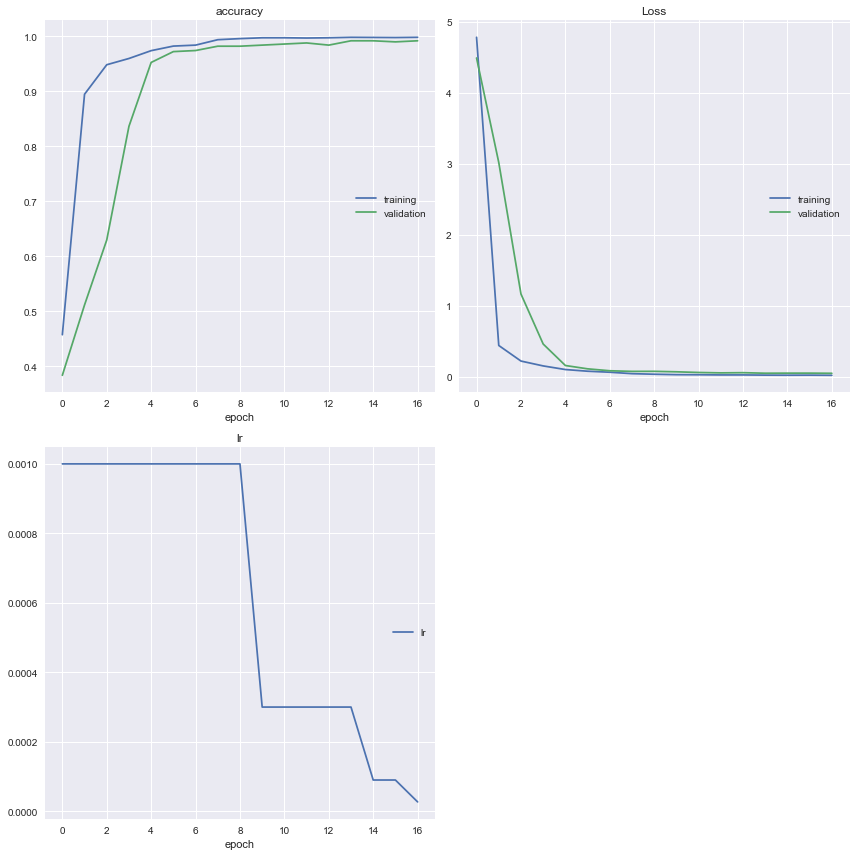

accuracy
	training         	 (min:    0.458, max:    0.998, cur:    0.998)
	validation       	 (min:    0.384, max:    0.992, cur:    0.992)
Loss
	training         	 (min:    0.019, max:    4.779, cur:    0.019)
	validation       	 (min:    0.047, max:    4.488, cur:    0.047)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
Epoch 00017: early stopping
Wall time: 31.1 s


In [11]:
%%time
history = model.fit(X_train,
                    Y_train,
                    batch_size=128,
                    epochs=50,
                    validation_data = (X_val, Y_val),
                    verbose = 1,
                    callbacks = [reduce_lr, early_stopping, PlotLossesKeras()])

#_, acc_temp = model.evaluate(X_test, Y_test)

#print('%.2f' % (np.mean(acc_temp)))

# model.save('CNN_Myopanda_1_w52_WG.hdf5')

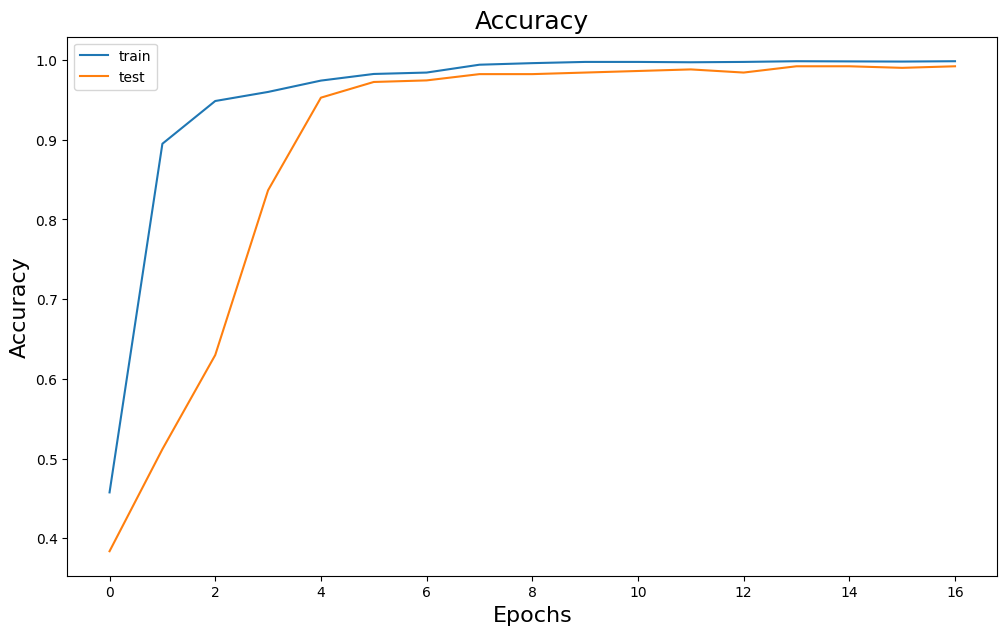

In [12]:
plt.style.use('default')
# plot accuracy during training
f = plt.figure(figsize=(12,7))
f = plt.title('Accuracy', fontsize = 18)
f = plt.plot(history.history['accuracy'], label='train')
f = plt.plot(history.history['val_accuracy'], label='test')
f = plt.legend()
f = plt.xlabel('Epochs', fontsize = 16)
f = plt.ylabel('Accuracy', fontsize = 16)
#plt.savefig('CNN_intrasession_raw.png')

In [45]:
y_pred = np.argmax(model.predict(X_val), axis=-1)
y_true = np.argmax(Y_val, axis = 1)
acc_dict = class_accuracy(y_pred, y_true)

In [46]:
acc_dict

{'0': [1.0],
 '1': [0.98],
 '2': [1.0],
 '3': [0.98],
 '4': [0.98],
 '5': [0.98],
 '6': [1.0],
 '7': [1.0]}

Save figure? (y:1, n:0)0


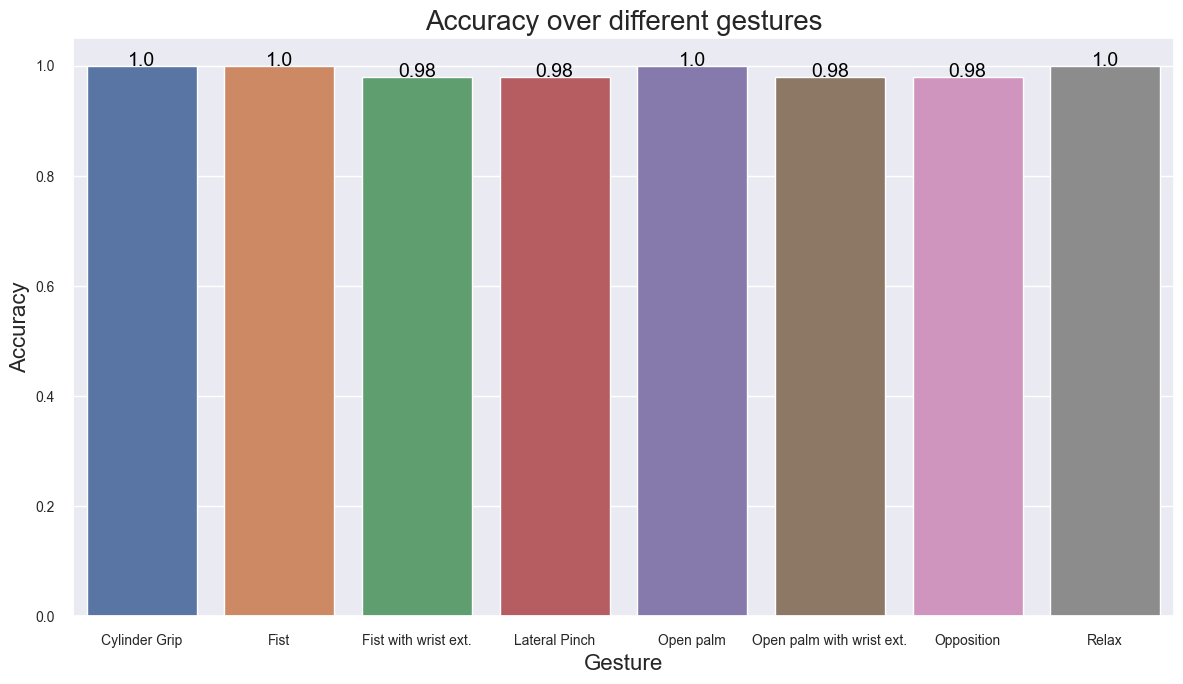

In [47]:
gesture_list = ['Fist', 'Fist with wrist ext.', 'Open palm', 'Open palm with wrist ext.', 'Opposition', 'Lateral Pinch', 'Cylinder Grip', 'Relax']
class_accuracy_plot(acc_dict, gesture_list)

# Read retraining dataset

In [48]:
X_retrain, y_retrain = read_file(mode = 1, window_size = 52, nonoverlap_size = 5)

100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]


# Read Test dataset

In [49]:
X_test, y_test = read_file(mode = 2, window_size = 52, nonoverlap_size = 5)

100%|█████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


In [50]:
X_retrain = scaler.transform(X_retrain.reshape(-1, X_retrain.shape[-1])).reshape(X_retrain.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

y_retrain = le.transform(y_retrain)
y_retrain = to_categorical(y_retrain)

y_test = le.transform(y_test)
y_test = to_categorical(y_test)

In [51]:
X_retrain = X_retrain.reshape(-1, 52, 8, 1)
X_test = X_test.reshape(-1, 52, 8, 1)

In [52]:
# Performance before retraining
model.evaluate(X_test, y_test)

159/159 [==============================] - 1s 4ms/step - loss: 0.2265 - accuracy: 0.9167


[0.22651657462120056, 0.9167158603668213]

In [58]:
# model = keras.models.load_model('CNN_Myopanda_1_w52_WG.hdf5')

In [53]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis = 1)
acc_dict = class_accuracy(y_pred, y_true)
print(acc_dict)

{'0': [0.99], '1': [0.96], '2': [0.89], '3': [1.0], '4': [0.57], '5': [1.0], '6': [0.95], '7': [1.0]}


Save figure? (y:1, n:0)0


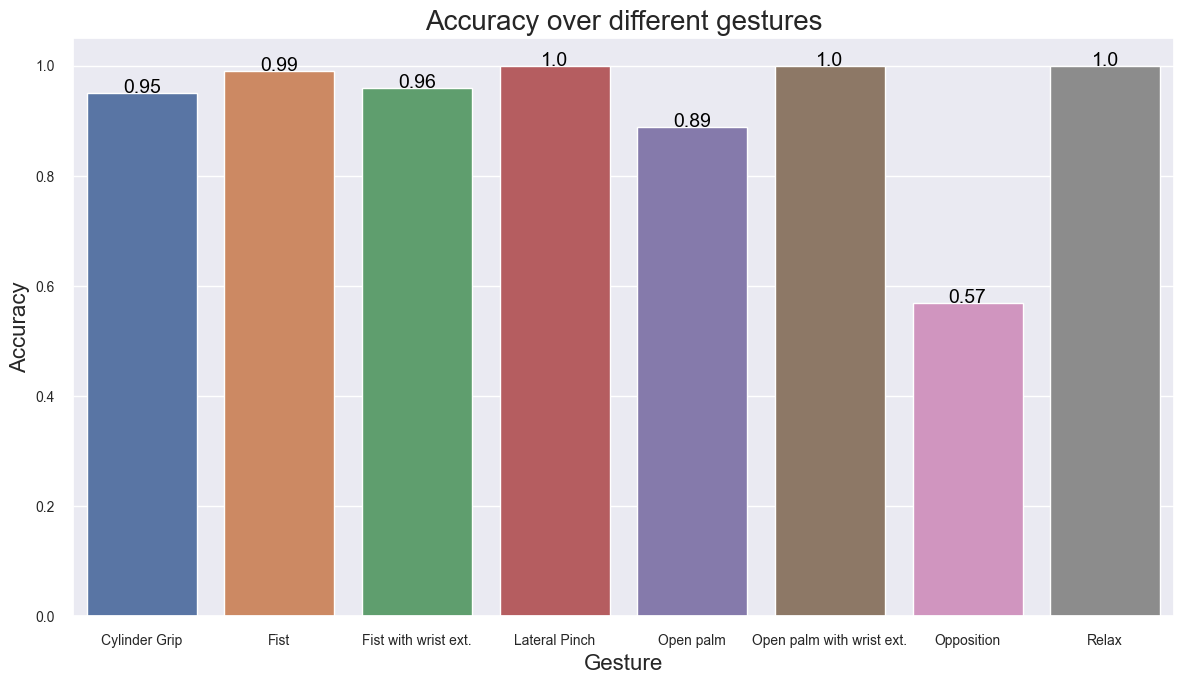

In [54]:
class_accuracy_plot(acc_dict, gesture_list)

# Retraining

In [56]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.3, patience=2, 
                                                 verbose=1, mode='auto', min_delta = 0.01)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=5, verbose=1,
    mode='auto', min_delta = 0.01)
model.fit(X_retrain, y_retrain, epochs = 20, callbacks = [reduce_lr, early_stopping])

Epoch 1/20
163/163 [==============================] - 1s 9ms/step - loss: 0.1020 - accuracy: 0.9662
Epoch 2/20
163/163 [==============================] - 1s 7ms/step - loss: 0.0794 - accuracy: 0.9716
Epoch 3/20
163/163 [==============================] - 1s 7ms/step - loss: 0.0726 - accuracy: 0.9760
Epoch 4/20
163/163 [==============================] - 1s 7ms/step - loss: 0.0655 - accuracy: 0.9775
Epoch 5/20
163/163 [==============================] - 1s 7ms/step - loss: 0.0579 - accuracy: 0.9798
Epoch 6/20
163/163 [==============================] - 1s 7ms/step - loss: 0.0580 - accuracy: 0.9814

Epoch 00006: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
Epoch 7/20
163/163 [==============================] - 1s 8ms/step - loss: 0.0499 - accuracy: 0.9848
Epoch 8/20
163/163 [==============================] - 1s 7ms/step - loss: 0.0497 - accuracy: 0.9846
Epoch 9/20
163/163 [==============================] - 1s 7ms/step - loss: 0.0500 - accuracy: 0.9848

Epoch 00009: Reduc

In [57]:
model.evaluate(X_test, y_test)

159/159 [==============================] - 1s 4ms/step - loss: 0.0587 - accuracy: 0.9789


[0.0586715005338192, 0.9789328575134277]

In [59]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis = 1)
acc_dict = class_accuracy(y_pred, y_true)

Save figure? (y:1, n:0)0


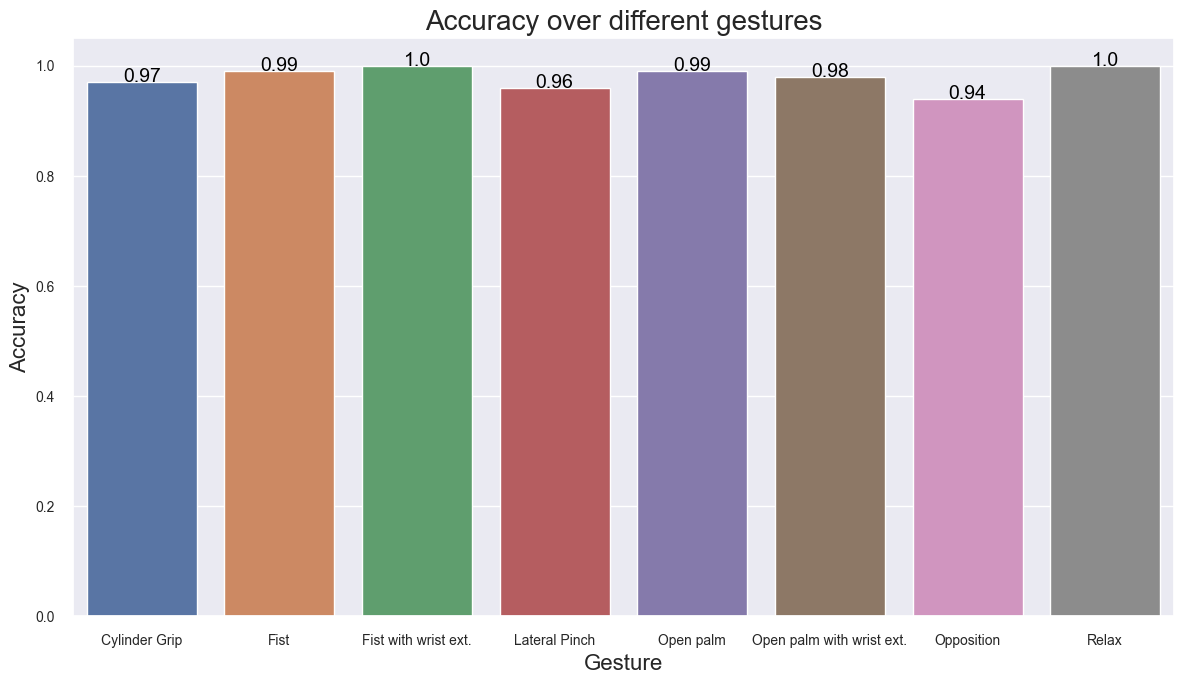

In [60]:
class_accuracy_plot(acc_dict, gesture_list)